In [1]:
#meta 10/19/2020 myStudy Ch9. Tabular Modeling - replicate with a simpler dataset Used Cars (from Kaggle)
# dataset source https://www.kaggle.com/avikasliwal/used-cars-price-prediction
#note: this dataset is probably not big enough for DL but it's good practice for RF.

#add'l reqs 
# package: dtreeviz
# conda install -c michal-a dtreeviz
# package: treeinterpeter
# conda install -c brown-data-science treeinterpreter
# package: waterfall_charts
# pip install waterfallcharts (no conda, but shows up installed in conda)

#history: 
#prev: 10/19/2020 a rough draft. revisit after saving to git.
#here: 10/20/20202 better organized, redid some feeature selection.

#focused on
# data prep
# feature selection
# RF model and visualizations
# fastai.collab nn model

In [2]:
#hide
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

In [3]:
#hide
from fastbook import *
##from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

import regex as re

# Tabular Modeling - Predict Used Car Sales Price
#### my Shallow Dive
The objective is to predict the value in one column based on the values in the other columns

## Categorical Embeddings
Continuous and Categorical Variables:  
- Continuous variables are numerical data, that can be directly fed to the model.  
- Categorical variables contain a number of discrete levels, for which addition and multiplication don't have meaning -> need to be converted to numbers

## Beyond Deep Learning
Modern machine learning can be distilled down to a couple of key techniques that are widely applicable. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

1. Ensembles of decision trees (i.e., random forests and gradient boosting machines), mainly for structured data (such as you might find in a database table at most companies)
1. Multilayered neural networks learned with SGD (i.e., shallow and/or deep learning), mainly for unstructured data (such as audio, images, and natural language)

Ensembles of decision trees tend to train faster, are often easier to interpret, do not require special GPU hardware for inference at scale, and often require less hyperparameter tuning. 

Most importantly, the critical step of interpreting a model of tabular data is significantly easier for decision tree ensembles. There are tools and methods for answering the pertinent questions, like:  
- Which columns in the dataset were the most important for your predictions? 
- How are they related to the dependent variable?  
- How do they interact with each other?  
- And which particular features were most important for some particular observation?

Therefore, ensembles of decision trees are our first approach for analyzing a new tabular dataset.

## 0. Load Data
The Dataset: Kaggle Used Cars  
Way smaller dataset.  Here, skipped official loading from Kaggle and just downloaded as csv. 

https://www.kaggle.com/avikasliwal/used-cars-price-prediction


In [4]:
path = URLs.path('kaggle_usedcars')
path

Path('/home/jupyter/.fastai/archive/kaggle_usedcars')

In [5]:
#hide
Path.BASE_PATH = path

In [6]:
# original when path didn't exist 
if not path.exists():
    path.mkdir()
    ##manually uploaded file in this small example, with not train-valid-test files available


In [7]:
path.ls(file_type='text')

(#3) [Path('train-data.csv'),Path('auto-mpg.csv'),Path('test-data.csv')]

### 0.1 EDA and Data Prep

In [8]:
df = pd.read_csv(path/'train-data.csv', low_memory=False)
print(df.shape)
df.head()

(6019, 14)


,Unnamed: 0,Name,Location,Year,...,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,...,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,...,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,...,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,...,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,...,140.8 bhp,5.0,NaN,17.74


In [9]:
df.columns, df.dtypes

(Index(['Unnamed: 0', 'Name', 'Location', 'Year', 'Kilometers_Driven',
        'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power',
        'Seats', 'New_Price', 'Price'],
       dtype='object'),
 Unnamed: 0             int64
 Name                  object
 Location              object
 Year                   int64
 Kilometers_Driven      int64
 Fuel_Type             object
 Transmission          object
 Owner_Type            object
 Mileage               object
 Engine                object
 Power                 object
 Seats                float64
 New_Price             object
 Price                float64
 dtype: object)

In [10]:
#rename columns
df.columns = ['car_id', 'Name', 'Location', 'Year', 'Kilometers_Driven',
        'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power',
        'Seats', 'New_Price', 'Price']

#use list comprehension to convert to lower case
df.columns = [x.lower() for x in df.columns]

#view column names
df.columns


Index(['car_id', 'name', 'location', 'year', 'kilometers_driven', 'fuel_type',
       'transmission', 'owner_type', 'mileage', 'engine', 'power', 'seats',
       'new_price', 'price'],
      dtype='object')

In [11]:
#check for missing values
df.isnull().sum()

car_id                  0
name                    0
location                0
year                    0
kilometers_driven       0
fuel_type               0
transmission            0
owner_type              0
mileage                 2
engine                 36
power                  36
seats                  42
new_price            5195
price                   0
dtype: int64

In [12]:
df.nunique()

car_id               6019
name                 1876
location               11
year                   22
kilometers_driven    3093
fuel_type               5
transmission            2
owner_type              4
mileage               442
engine                146
power                 372
seats                   9
new_price             540
price                1373
dtype: int64

#### Ordinal categories

In [13]:
#expore 
df['owner_type'].unique()

array(['First', 'Second', 'Fourth & Above', 'Third'], dtype=object)

In [14]:
#ordinal columns
owner_type_order = 'First', 'Second', 'Third','Fourth & Above', #class tuple

# make cylinders into categories
df['owner_type_cat'] = df['owner_type']
df['owner_type_cat'] = df['owner_type_cat'].astype('category')
#df['owner_type_cat'].cat.codes
df['owner_type_cat'].cat.set_categories(owner_type_order, ordered=True, inplace=True)

First             4929
Second             968
Third              113
Fourth & Above       9
Name: owner_type_cat, dtype: int64


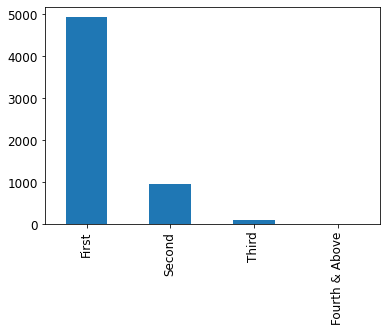

In [15]:
print(df['owner_type_cat'].value_counts())
df['owner_type_cat'].value_counts().plot(kind = 'bar');

#### Impute Missing Values

In [16]:
#Seats impute missing values
print("median: ", df['seats'].median())

median:  5.0


In [17]:
idx_missing_seats = df[df['seats'].isnull()].index
idx_missing_seats

Int64Index([ 194,  208,  229,  733,  749, 1294, 1327, 1385, 1460, 1917, 2074,
            2096, 2264, 2325, 2335, 2369, 2530, 2542, 2623, 2668, 2737, 2780,
            2842, 3272, 3404, 3520, 3522, 3800, 3810, 3882, 4011, 4152, 4229,
            4577, 4604, 4697, 4712, 4952, 5015, 5185, 5270, 5893],
           dtype='int64')

In [18]:
print(df.iloc[194]['seats'])
df.loc[idx_missing_seats, 'seats'] = df['seats'].median()
#confirm
df.iloc[194]['seats']

nan


5.0

#### Continuous variables
manually

In [19]:
#mileage or km/l
df['mileage_num'] = df['mileage'].str.replace('\s(.*)','', regex=True)
df['mileage_num'] = df['mileage_num'].fillna(0).astype('float')

In [20]:
#engine
df['engine_num'] = df['engine'].str.replace('\s(.*)','', regex=True)
df['engine_num'] = df['engine_num'].fillna(0).astype(float)

In [21]:
#power
df['power_num'] = df['power'].str.replace('\s(.*)','', regex=True)
df['power_num'] = df['power_num'].str.replace('null','0', regex=True) #$note: a strange value 'null'
df['power_num'] = df['power_num'].fillna(0).astype(float)


In [22]:
#engine
df['new_price_num'] = df['new_price'].str.replace('\s(.*)','', regex=True)
df['new_price_num'] = df['new_price_num'].fillna(0).astype(float)

In [23]:
#review preprocessed dataset 
print(df.dtypes)
#preview with cat columns
df.loc[::10]

car_id                  int64
name                   object
location               object
year                    int64
kilometers_driven       int64
fuel_type              object
transmission           object
owner_type             object
mileage                object
engine                 object
power                  object
seats                 float64
new_price              object
price                 float64
owner_type_cat       category
mileage_num           float64
engine_num            float64
power_num             float64
new_price_num         float64
dtype: object


,car_id,name,location,year,...,mileage_num,engine_num,power_num,new_price_num
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,...,26.60,998.0,58.16,0.00
10,10,Maruti Ciaz Zeta,Kochi,2018,...,21.56,1462.0,103.25,10.65
20,20,BMW 3 Series 320d,Kochi,2014,...,22.69,1995.0,190.00,47.87
30,30,Renault Duster 110PS Diesel RxZ Pack,Bangalore,2013,...,19.01,1461.0,108.45,0.00
40,40,Maruti Alto LXi,Delhi,2008,...,19.70,796.0,46.30,0.00
...,...,...,...,...,...,...,...,...,...
5970,5970,Mercedes-Benz GLA Class 200 Sport,Kochi,2018,...,13.70,1991.0,183.00,39.22
5980,5980,Hyundai i20 2015-2017 Magna,Pune,2010,...,18.50,1197.0,80.00,0.00
5990,5990,Tata New Safari DICOR 2.2 VX 4x2,Pune,2008,...,13.93,2179.0,138.00,0.00
6000,6000,Hyundai i20 Sportz 1.2,Bangalore,2014,...,18.50,1197.0,82.85,0.00


In [24]:
##df[dep_var] = np.log(df[dep_var])
dep_var = 'price'

In [25]:
print(df.shape)
df.head()

(6019, 19)


,car_id,name,location,year,...,mileage_num,engine_num,power_num,new_price_num
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,...,26.60,998.0,58.16,0.00
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,...,19.67,1582.0,126.20,0.00
2,2,Honda Jazz V,Chennai,2011,...,18.20,1199.0,88.70,8.61
3,3,Maruti Ertiga VDI,Chennai,2012,...,20.77,1248.0,88.76,0.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,...,15.20,1968.0,140.80,0.00


## 1.  Model
### 1.1 Decision Trees
A decision tree asks a series of binary questions about the data. After each question the data at that part of the tree is split between a "yes" and a "no" branch. After one or more questions, either a prediction can be made on the basis of all previous answers or another question is required.


#### Handling Dates
No dates here. But if there were, for data preparation we need to enrich our representation of dates. 

In [26]:
np.sort(df['year'].unique())

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

### Using TabularPandas and TabularProc
Another piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class `TabularPandas`, which wraps a Pandas DataFrame and provides a few conveniences. To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

`Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing. These two transforms are needed for nearly every tabular dataset you will use, so this is a good starting point for your data processing:

In [27]:
procs = [Categorify, FillMissing]

`TabularPandas` will also handle splitting the dataset into training and validation sets for us. However we need to be very careful about our validation set. We want to design it so that it is like the *test set* Kaggle will use to judge the contest.  

In some cases, i.e. with a time series, just randomly choosing a subset of your data points will do that. 

This is not a time series, therefore can use default random split.

In [28]:
##cond = (df.Year<2017)
##train_idx = np.where( cond)[0]
##valid_idx = np.where(~cond)[0]

In [29]:
#my random split
n_size = df.shape[0]
n_train_size = int(n_size *.8)
print(n_size, n_train_size)

idx = np.arange(n_size)
np.random.shuffle(idx)
train_idx, valid_idx = idx[:n_train_size], idx[n_train_size:]
print(len(train_idx), len(valid_idx))

splits = (list(train_idx),list(valid_idx))


6019 4815
4815 1204


`TabularPandas` needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function `cont_cat_split`:

In [30]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
#mycheck
cont, cat

(['car_id',
  'year',
  'kilometers_driven',
  'seats',
  'mileage_num',
  'engine_num',
  'power_num',
  'new_price_num'],
 ['name',
  'location',
  'fuel_type',
  'transmission',
  'owner_type',
  'mileage',
  'engine',
  'power',
  'new_price',
  'owner_type_cat'])

In [31]:
#my
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits) #class fastai.tabular.core.TabularPandas
len(to.train),len(to.valid)

(4815, 1204)

In [32]:
to.show(3)

,name,location,fuel_type,transmission,owner_type,mileage,engine,power,new_price,owner_type_cat,car_id,year,kilometers_driven,seats,mileage_num,engine_num,power_num,new_price_num,price
2868,Maruti Swift Dzire VDI,Hyderabad,Diesel,Manual,First,23.4 kmpl,1248 CC,74 bhp,#na#,First,2868,2013,69000,5.0,23.4,1248.0,74.0,0.0,5.75
5924,Mahindra Scorpio 1.99 S4 Plus,Kochi,Diesel,Manual,First,15.4 kmpl,1997 CC,120 bhp,#na#,First,5924,2017,26741,7.0,15.4,1997.0,120.0,0.0,10.08
3764,Mahindra XUV500 W8 2WD,Delhi,Diesel,Manual,First,15.1 kmpl,2179 CC,140 bhp,#na#,First,3764,2014,86000,7.0,15.1,2179.0,140.0,0.0,7.85


In [33]:
to.items.head(3)

,car_id,name,location,year,...,mileage_num,engine_num,power_num,new_price_num
2868,2868,1136,6,2013,...,23.4,1248.0,74.0,0.0
5924,5924,865,8,2017,...,15.4,1997.0,120.0,0.0
3764,3764,925,5,2014,...,15.1,2179.0,140.0,0.0


In [34]:
to.classes['owner_type_cat']

(#5) ['#na#','First','Second','Third','Fourth & Above']

In [35]:
#done preprocessing, save
(path/'to.pkl').save(to)

### Creating the Decision Tree

In [36]:
#hide
to = (path/'to.pkl').load()

In [37]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [38]:
xs.shape

(4815, 18)

In [39]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

In [40]:
#original - partial diagram, can't see full tree
#draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

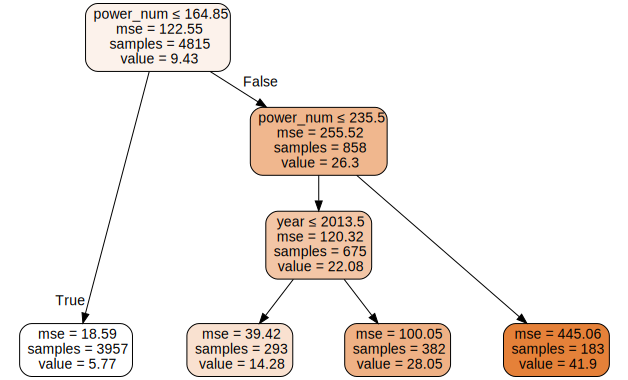

In [41]:
#$myfix
#draw_tree??
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [42]:
#original - get error dtreeviz() got an unexpected keyword argument 'scale'
#samp_idx = np.random.permutation(len(y))[:500]
#dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
#        fontname='DejaVu Sans', scale=1.6, label_fontsize=10, orientation='LR')

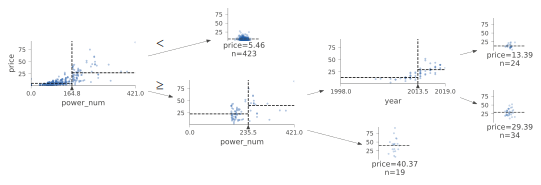

In [43]:
#myfix - without scale
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans',  label_fontsize=10,
        orientation='LR') #scale=1.6,

In [44]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [45]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [46]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.0, 6.696872)

In [47]:
m.get_n_leaves(), len(xs)

(4531, 4815)

In [48]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(4.154048, 5.32644)

In [49]:
m.get_n_leaves()

150

### Categorical Variables

## Random Forests

In [50]:
#hide
# pip install —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

### Creating a Random Forest

In [51]:
def rf(xs, y, n_estimators=40, max_samples=2000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [52]:
m = rf(xs, y);

In [53]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(3.345749, 4.826908)

In [54]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [55]:
r_mse(preds.mean(0), valid_y)

4.826908

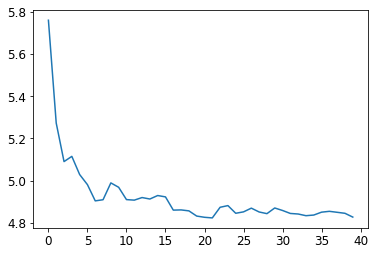

In [56]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-Bag Error

In [57]:
r_mse(m.oob_prediction_, y)

4.003384

## Model Interpretation

### Tree Variance for Prediction Confidence

In [58]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [59]:
preds.shape

(40, 1204)

In [60]:
preds_std = preds.std(0)

In [61]:
preds_std[:5]

array([7.62269741, 1.07484825, 0.95108134, 3.43134758, 0.79000831])

### Feature Importance

In [62]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [63]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
16,power_num,0.347528
15,engine_num,0.202859
11,year,0.112647
3,transmission,0.087253
7,power,0.074054
12,kilometers_driven,0.068009
17,new_price_num,0.021020
6,engine,0.018930
0,name,0.017199
14,mileage_num,0.011447


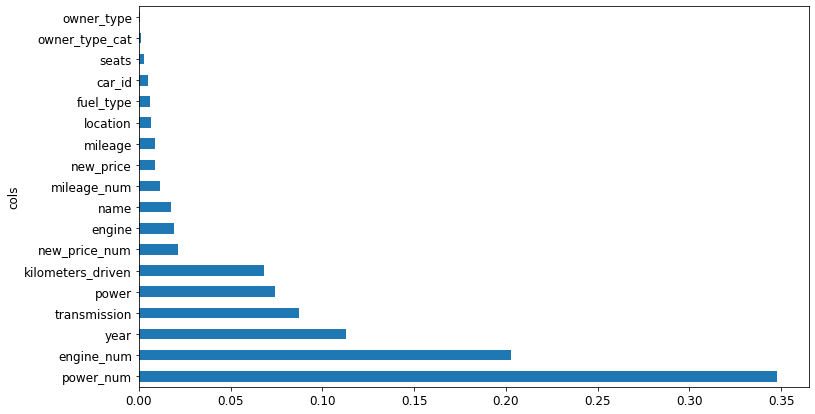

In [64]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

#### Redundant Features

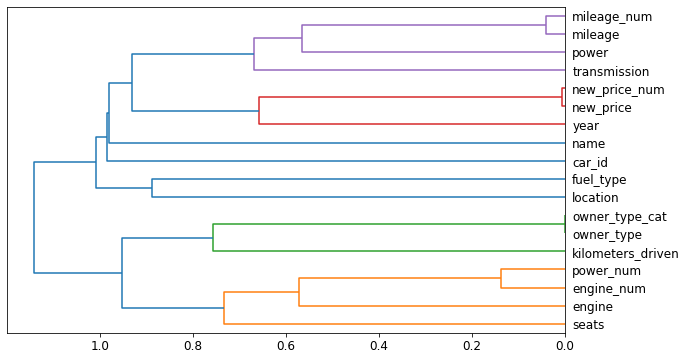

In [65]:
cluster_columns(xs)

### Removing Low-Importance Variables

In [66]:
#original
to_keep = fi[fi.imp>0.005].cols
print(to_keep)
len(to_keep)

16            power_num
15           engine_num
11                 year
3          transmission
7                 power
12    kilometers_driven
17        new_price_num
6                engine
0                  name
14          mileage_num
8             new_price
5               mileage
1              location
2             fuel_type
Name: cols, dtype: object


14

In [67]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [68]:
m = rf(xs_imp, y)

In [69]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(3.395673, 4.808788)

In [70]:
len(xs.columns), len(xs_imp.columns)

(18, 14)

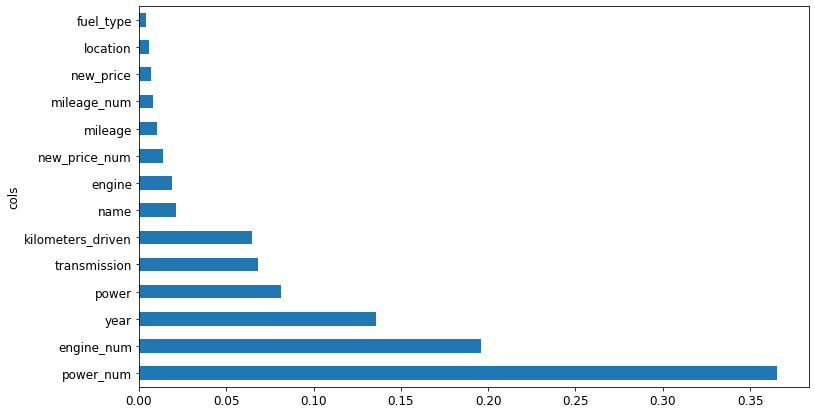

In [71]:
plot_fi(rf_feat_importance(m, xs_imp));

### Removing Redundant Features

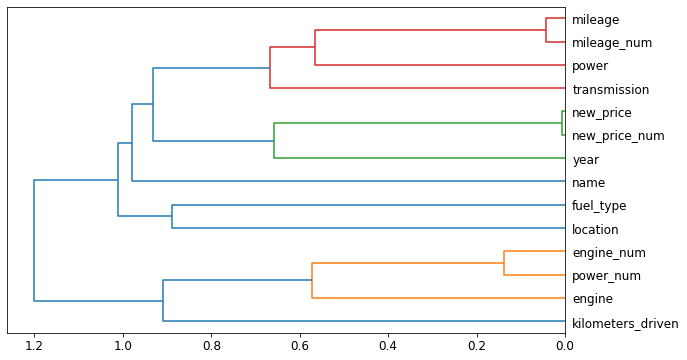

In [72]:
cluster_columns(xs_imp)

In [73]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=2000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

#### Baseline R-squared

In [74]:
get_oob(xs_imp)

0.8382613620646131

In [75]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
     'power', 'power_num', 'mileage', 'mileage_num', 'engine', 'engine_num', 'new_price', 'new_price_num')}

{'power': 0.8397959707567568,
 'power_num': 0.8273181539368433,
 'mileage': 0.8366736389908564,
 'mileage_num': 0.8357566626378332,
 'engine': 0.8341403188156703,
 'engine_num': 0.8310069612794921,
 'new_price': 0.8409468111150805,
 'new_price_num': 0.835661354232101}

In [76]:
to_drop = ['power', 'mileage', 'engine','new_price']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8459282632972918

In [77]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [78]:
(path/'xs_final.pkl').save(xs_final)
(path/'valid_xs_final.pkl').save(valid_xs_final)

In [79]:
xs_final = (path/'xs_final.pkl').load()
valid_xs_final = (path/'valid_xs_final.pkl').load()

In [80]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(3.314344, 4.771058)

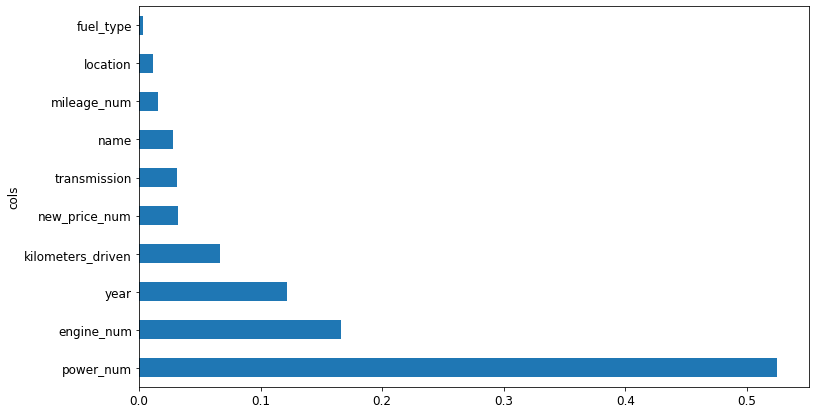

In [81]:
plot_fi(rf_feat_importance(m, xs_final));

### Partial Dependence

In [82]:
#p = valid_xs_final['power_num'].value_counts(sort=False).plot.barh() $actodo
#c = to.classes['owner_type_cat']
#plt.yticks(range(len(c)), c);

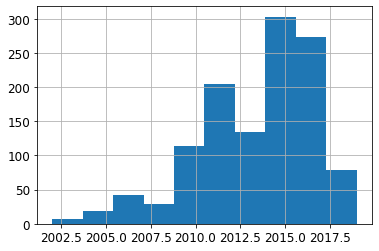

In [83]:
valid_xs_final['year'].hist();

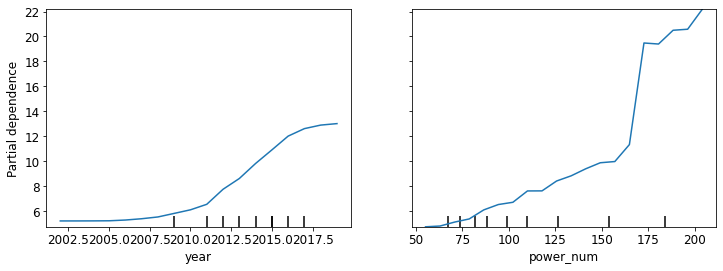

In [84]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['year','power_num'],
                        grid_resolution=20, ax=ax);

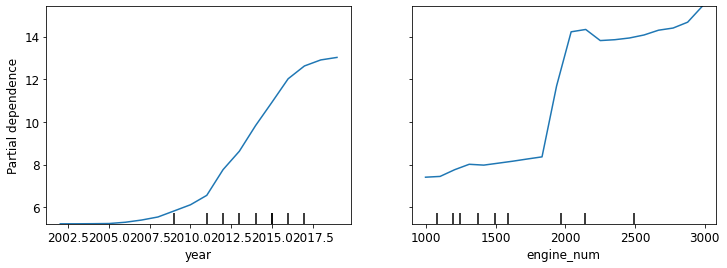

In [85]:
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['year','engine_num'],
                        grid_resolution=20, ax=ax);

### Data Leakage

### Tree Interpreter

In [86]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [87]:
row = valid_xs_final.iloc[:5]
row

,power_num,engine_num,year,transmission,...,name,mileage_num,location,fuel_type
5641,153.860001,2953.0,2012,1,...,270,11.40,8,2
3594,130.000000,1799.0,2008,2,...,467,13.50,2,5
1920,73.750000,1248.0,2016,2,...,1046,28.40,5,2
513,120.000000,1997.0,2017,2,...,866,15.40,5,2
4177,126.320000,1582.0,2012,2,...,634,22.32,6,2


In [88]:
#confirm shapes
m.n_features_

10

In [89]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [90]:
prediction[0], bias[0], contributions[0].sum()

(array([13.65540927]), 9.446716369690746, 4.20869290050508)

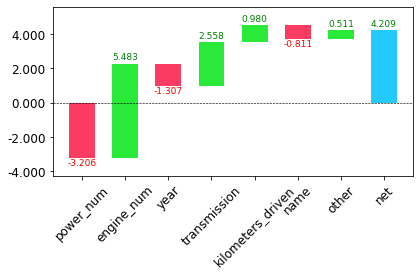

In [91]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

### The Extrapolation Problem
no time series here => n/a

### Finding Out-of-Domain Data
this section works but messes with my Ensemble later.  $actofix

In [92]:
##df_dom = pd.concat([xs_final, valid_xs_final])
##is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

##m = rf(df_dom, is_valid)
##rf_feat_importance(m, df_dom)[:6]

In [93]:
#m = rf(xs_final, y)
#print('orig', m_rmse(m, valid_xs_final, valid_y))

#for c in ('kilometers_driven','name', 'mileage_num', 'power_num', 'location', 'new_price_num'):
#    m = rf(xs_final.drop(c,axis=1), y)
#    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

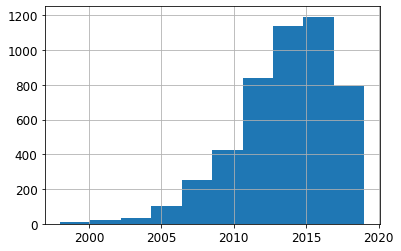

In [94]:
xs['year'].hist();

In [95]:
##check if ok to remove 'new_price?' - ok to keep too
#xtra_vars = ['new_price_num']
#xs_final_xtra = xs_final.drop(xtra_vars, axis=1)
#valid_xs_xtra = valid_xs_final.drop(xtra_vars, axis=1)

#m = rf(xs_final_xtra, y)
#m_rmse(m, valid_xs_xtra, valid_y)

### Using a Neural Network

In [144]:
df_nn = pd.read_csv(path/'train-data.csv', low_memory=False)

#duplicate data prep
df_nn.columns = ['car_id', 'Name', 'Location', 'Year', 'Kilometers_Driven',
        'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power',
        'Seats', 'New_Price', 'Price']

#use list comprehension to convert to lower case
df_nn.columns = [x.lower() for x in df_nn.columns]

#preprocess
#impute
idx_missing_seats = df[df['seats'].isnull()].index
idx_missing_seats
df.loc[idx_missing_seats, 'seats'] = df['seats'].median()

#convet to numeric
#mileage or km/l
df_nn['mileage_num'] = df_nn['mileage'].str.replace('\s(.*)','', regex=True)
df_nn['mileage_num'] = df_nn['mileage_num'].fillna(0).astype('float')

#engine
df_nn['engine_num'] = df_nn['engine'].str.replace('\s(.*)','', regex=True)
df_nn['engine_num'] = df_nn['engine_num'].fillna(0).astype(float)

#power
df_nn['power_num'] = df_nn['power'].str.replace('\s(.*)','', regex=True)
df_nn['power_num'] = df_nn['power_num'].str.replace('null','0', regex=True) #$note: a strange value 'null'
df_nn['power_num'] = df_nn['power_num'].fillna(0).astype(float)

#engine
df_nn['new_price_num'] = df_nn['new_price'].str.replace('\s(.*)','', regex=True)
df_nn['new_price_num'] = df_nn['new_price_num'].fillna(0).astype(float)

#ordinal - not including in the model
df_nn['owner_type_cat'] = df_nn['owner_type'].astype('category')
df_nn['owner_type_cat'].cat.set_categories(owner_type_order, ordered=True, inplace=True)

#target var
df_nn[dep_var] = df_nn[dep_var]


In [145]:
df_nn_final = df_nn[list(xs_final.columns) + [dep_var]]

print(df_nn_final.columns)
df_nn_final.dtypes

Index(['power_num', 'engine_num', 'year', 'transmission', 'kilometers_driven',
       'new_price_num', 'name', 'mileage_num', 'location', 'fuel_type',
       'price'],
      dtype='object')


power_num            float64
engine_num           float64
year                   int64
transmission          object
kilometers_driven      int64
new_price_num        float64
name                  object
mileage_num          float64
location              object
fuel_type             object
price                float64
dtype: object

In [146]:
#check for missing values
df_nn_final.notnull().sum()

power_num            6019
engine_num           6019
year                 6019
transmission         6019
kilometers_driven    6019
new_price_num        6019
name                 6019
mileage_num          6019
location             6019
fuel_type            6019
price                6019
dtype: int64

In [147]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=1500, dep_var=dep_var)

#if need to remove a field
##cat_nn.remove('field_name')

In [148]:
df_nn_final[cat_nn].nunique()

year              22
transmission       2
name            1876
location          11
fuel_type          5
dtype: int64

In [149]:
#my check 
print(df_nn_final.shape)
print(df_nn_final.columns)
print(len(cat_nn))
print(cat_nn)
print(len(cont_nn))
print(cont_nn)

(6019, 11)
Index(['power_num', 'engine_num', 'year', 'transmission', 'kilometers_driven',
       'new_price_num', 'name', 'mileage_num', 'location', 'fuel_type',
       'price'],
      dtype='object')
5
['year', 'transmission', 'name', 'location', 'fuel_type']
5
['power_num', 'engine_num', 'kilometers_driven', 'new_price_num', 'mileage_num']


In [150]:
#check dtypes
df_nn_final.dtypes

power_num            float64
engine_num           float64
year                   int64
transmission          object
kilometers_driven      int64
new_price_num        float64
name                  object
mileage_num          float64
location              object
fuel_type             object
price                float64
dtype: object

In [151]:
#original - error ValueError: Unable to coerce to Series, length must be 1: given 0
#refer to possible fix: https://forums.fast.ai/t/09-tabular-value-error-unable-to-coerce-to-series-length-must-be-1-given-0/80580/6
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [152]:
dls = to_nn.dataloaders(1024)

In [153]:
y = to_nn.train.y
y.min(),y.max()

(0.4399999976158142, 120.0)

In [154]:
#$note: ensure range
learn = tabular_learner(dls, y_range=(0, 120), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0012022644514217973)

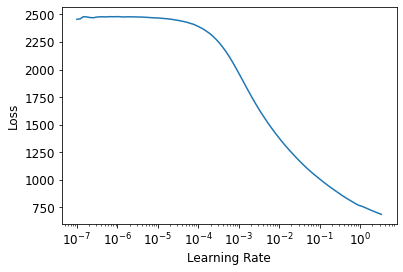

In [155]:
learn.lr_find()

In [156]:
learn.fit_one_cycle(15, 1e-1)

epoch,train_loss,valid_loss,time
0,815.991516,844.681152,00:00
1,461.042084,154.850922,00:00
2,335.693573,133.190460,00:00
3,267.144348,94.509186,00:00
4,224.053284,74.338387,00:00
5,191.805511,87.937645,00:00
6,166.673019,52.446075,00:00
7,146.605896,49.431606,00:00
8,129.861313,44.696278,00:00
9,115.889046,42.537945,00:00


In [157]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

6.259515

In [158]:
learn.save('nn_my09_used_cars')

Path('models/nn_my09_used_cars.pth')

### Sidebar: fastai's Tabular Classes

### End sidebar

## Ensembling

In [159]:
#valid_xs_final = valid_xs_final.drop('new_price', axis=1)
valid_xs_final.dtypes,  xs_final.dtypes

(power_num            float32
 engine_num           float32
 year                   int16
 transmission            int8
 kilometers_driven      int32
 new_price_num        float32
 name                   int16
 mileage_num          float32
 location                int8
 fuel_type               int8
 dtype: object,
 power_num            float32
 engine_num           float32
 year                   int16
 transmission            int8
 kilometers_driven      int32
 new_price_num        float32
 name                   int16
 mileage_num          float32
 location                int8
 fuel_type               int8
 dtype: object)

In [160]:
#rf_preds = m.predict(valid_xs_time)
rf_preds = m.predict(valid_xs_final)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [161]:
r_mse(ens_preds,valid_y)

4.922593

## Conclusion: Our Advice for Tabular Modeling
2 approaches: 1) ensemble models and 2) neural nets.  
Suggest starting with a random forest, which gives you a stong baseline. Then use that model for feature selection and partial data analysis to better understand your data. Then try neural nets and GBMs.  

## Further Research

1. Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare your results to the private leaderboard.
1. Implement the decision tree algorithm in this chapter from scratch yourself, and try it on the datase you used in the first exercise.
1. Use the embeddings from the neural net in this chapter in a random forest, and see if you can improve on the random forest results we saw.
1. Explain what each line of the source of `TabularModel` does (with the exception of the `BatchNorm1d` and `Dropout` layers).